# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numbers
import operator

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

print("Libraries successfully imported!")

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

Libraries successfully imported!


'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')  

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('Number of rows in AZDIAS dataset: ', azdias.shape[0])
print('Number of columns in AZDIAS dataset: ', azdias.shape[1])
print('*'*50)
print('Number of rows in Feature Summary file: ', feat_info.shape[0])
print('Number of columns in Feature Summary file: ', feat_info.shape[1])

Number of rows in AZDIAS dataset:  891221
Number of columns in AZDIAS dataset:  85
**************************************************
Number of rows in Feature Summary file:  85
Number of columns in Feature Summary file:  4


In [4]:
print('First few rows of AZDIAS dataset:')
azdias.head(5)

First few rows of AZDIAS dataset:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print('Summary statistics for AZDIAS dataset:')
azdias.describe()

Summary statistics for AZDIAS dataset:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
print('First few rows of Feature Summary file:')
feat_info.head(5)

First few rows of Feature Summary file:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
print('Entire Feature Summary file:')
feat_info

Entire Feature Summary file:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify originally missing values per column in AZDIAS dataset.
originally_missing_columns = azdias.isnull().sum() 

print('Number of naturally missing values per AZDIAS dataset column:')
originally_missing_columns

Number of naturally missing values per AZDIAS dataset column:


AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
for attribute, missing_values_list in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
    # Strip string values of formatting elements and split values.
    missing_values_list = missing_values_list.strip('[]').split(',')
    
    for value in missing_values_list: 
        # If value in missing values list is numeric, convert into integer type. 
        try:
            value = int(value)
        except:
            continue
        # Convert respective AZDIAS value to NaN. 
        azdias.loc[azdias[attribute] == value, attribute] = np.nan

In [10]:
# Print first few lines of AZDIAS dataset to verify that missing or unknown values are successfully converted to NaNs.
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [11]:
# Print the total number of missing or unknown values. 
print('Total number of missing or unknown values in AZDIAS dataset: ', azdias.isnull().sum().sum())

Total number of missing or unknown values in AZDIAS dataset:  8372810


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#Compare number of naturally missing values in AZDIAS dataset to number of missing values per column after conversion.
updated_missing_columns = azdias.isnull().sum() 

before = pd.Series(originally_missing_columns, name = 'original nr. of missing or unknown values')
after = pd.Series(updated_missing_columns, name = 'updated nr. of missing or unknown values')

pd.concat([before, after], axis=1)


,original nr. of missing or unknown values,updated nr. of missing or unknown values
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


In [13]:
# Investigate patterns in the amount of missing data in each column.

# Calculate percentage of missing values per column
n_rows = azdias.shape[0] # total number of rows in dataset 
percentage_missing_columns = (updated_missing_columns / n_rows) * 100
percentage_missing_columns = pd.Series(percentage_missing_columns, name = '%_values_missing')

print('Updated nr. of missing or unknown values in %')
percentage_missing_columns

Updated nr. of missing or unknown values in %


AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

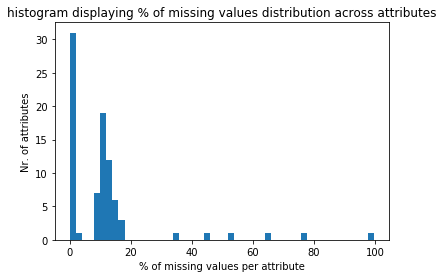

In [14]:
# Visualize the distribution of missing value counts per column via a Histogram
plt.hist(percentage_missing_columns, bins = 50)
plt.xlabel('% of missing values per attribute')
plt.ylabel('Nr. of attributes')
plt.title('histogram displaying % of missing values distribution across attributes')
plt.show()

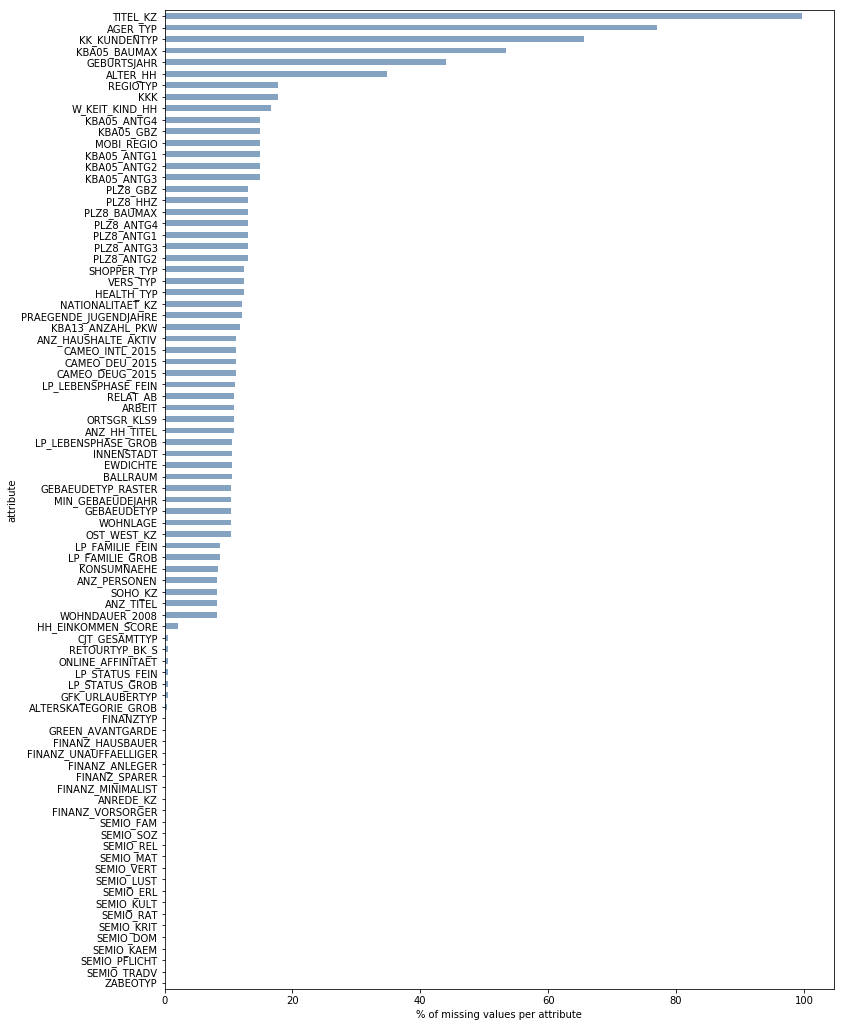

In [15]:
# Display data in order of descending percentage of missing values. 
percentage_missing_columns.sort_values(ascending = True, inplace = True)
percentage_missing_columns.plot.barh(figsize=(12,18), color=(0.2, 0.4, 0.6, 0.6))
plt.xlabel('% of missing values per attribute')
plt.ylabel('attribute')
plt.show()

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Out of 85 attributes only 6 attributes have a % of missing values significantly higher than 18% 
#(i.e. more than 200000 missing values). Therefore, the following removes these 6 attributes as outliers. 
updated_missing_columns = pd.DataFrame(updated_missing_columns, columns = ['values_missing_columns'])

outliers = updated_missing_columns[updated_missing_columns['values_missing_columns'] > 0.18 * n_rows]
# print('Outlier attributes to be removed with corresponding % of missing values: \n', outliers)
print('*' * 70)

azdias_clean = azdias.drop(outliers.index, axis = 1)

print("Outliers have been successfully removed from AZDIAS dataset.")

**********************************************************************
Outliers have been successfully removed from AZDIAS dataset.


In [17]:
# Also remove the outlier features from the feat_info dataset. 
feat_info_clean = feat_info.set_index("attribute")
for i, j in outliers.iterrows(): 
    feat_info_clean.drop(i, axis=0, inplace = True) 

#### Discussion 1.1.2: Assess Missing Data in Each Column

As can be seen from the bar chart, the majority of attributes in the AZDIAS dataset have either no or few missing values. Only 6 of the 85 attributes in the dataset have a percentage of missing values significantly higher than 18% of the total values. Therefore, I decided to consider these 6 attributes as outliers in terms of their number of missing values, and removed these from the dataset. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
missing_rows = pd.DataFrame(azdias_clean.isnull().sum(axis = 1), columns = ['values_missing_rows'])
print('Number of values missing in first 20 rows of AZDIAS dataset:')
missing_rows.head(20)

Number of values missing in first 20 rows of AZDIAS dataset:


,values_missing_rows
0,43
1,0
2,0
3,7
4,0
5,0
6,0
7,0
8,0
9,0


In [19]:
# Display summary statistics on number of missing values per row 
missing_rows.describe()

,values_missing_rows
count,891221.000000
mean,5.648638
std,13.234726
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f465ba832b0>]], dtype=object)

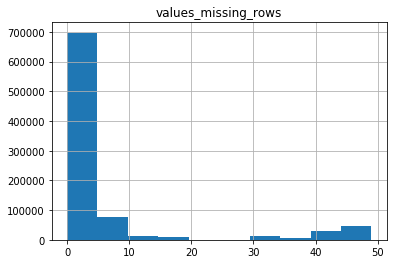

In [20]:
# Visualize the distribution of missing value counts per row via a Histogram. 
missing_rows.hist()

In [21]:
# Add number of missing values per row to AZDIAS dataset 
azdias_joined = azdias_clean.join(missing_rows) 

# Print first 5 rows in AZDIAS dataset to verify successful merger: 
azdias_joined.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,values_missing_rows
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_fewer_missing = azdias_joined[azdias_joined['values_missing_rows'] <= 25]
azdias_more_missing = azdias_joined[azdias_joined['values_missing_rows'] > 25]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4659348048>]], dtype=object)

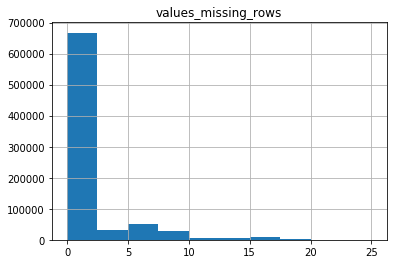

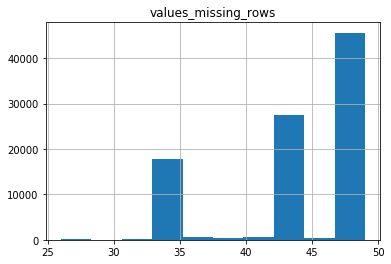

In [23]:
# Verify successful split by plotting histograms of both datasets.
missing_rows_1 = pd.DataFrame(azdias_fewer_missing.isnull().sum(axis = 1), columns = ['values_missing_rows'])
missing_rows_2 = pd.DataFrame(azdias_more_missing.isnull().sum(axis = 1), columns = ['values_missing_rows'])
missing_rows_1.hist()
missing_rows_2.hist()

In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Identify 5 columns with no missing values 
zero_missing = updated_missing_columns[updated_missing_columns['values_missing_columns'] == 0]
comparison_columns = zero_missing[:5]
print('5 Columns with no missing values for comparison: \n', comparison_columns)

5 Columns with no missing values for comparison: 
                    values_missing_columns
ANREDE_KZ                               0
FINANZ_MINIMALIST                       0
FINANZ_SPARER                           0
FINANZ_VORSORGER                        0
FINANZ_ANLEGER                          0


In [25]:
# Function that creates comparison subplots of both datasets per specified column.
def compare_values(set_1, set_2, column): 
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax[0].set_title('less than 25 missing values group')
    sns.countplot(set_1[column], ax=ax[0])
    ax[1].set_title('more than 25 missing values group')
    sns.countplot(set_2[column], ax=ax[1])
    plt.show()

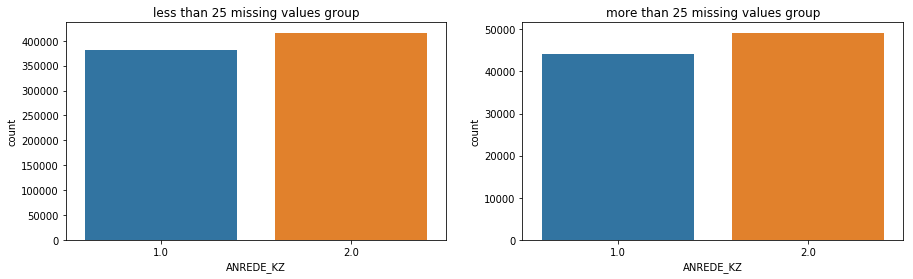

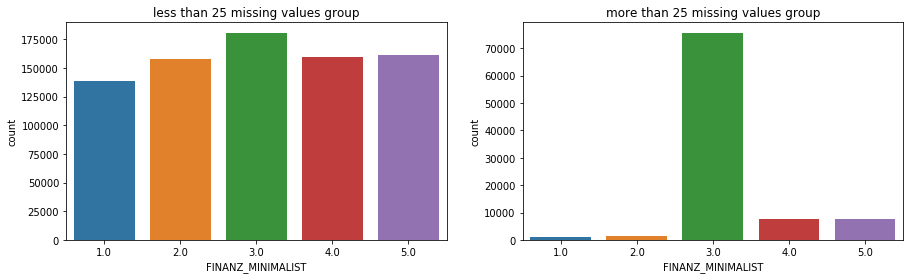

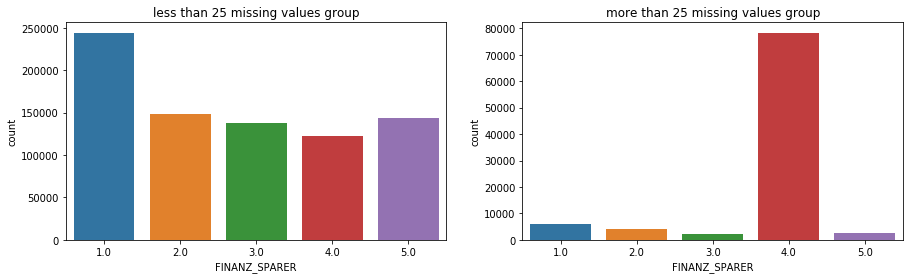

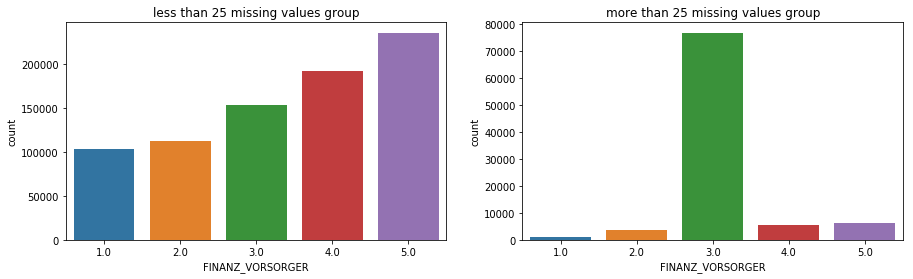

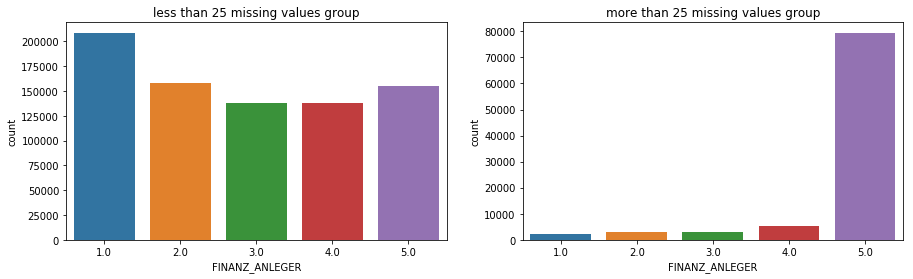

In [26]:
# Iterate through the dataframe containing the 5 columns with no missing values and plot the respective subplots. 
for i, j in comparison_columns.iterrows(): 
    compare_values(azdias_fewer_missing, azdias_more_missing, i) 

#### Discussion 1.1.3: Assess Missing Data in Each Row

As can be discerned from the Histogram plot of the number of missing values per entitity, the majority of values has less than 6 missing values. Visually, two groups of entitites can be distinguished: entities with less than 25 missing values and entities with 25-50 missing values. Therefore, I decided to split the data accordingly. 

From the comparison between the two groups along 5 columns with no missing values, it can be discerned that there are strong, sustematic differences between both subsets of the AZDIAS dataset in terms of missing values. It might therefore be wise to only utilize the dataset with entities containing less than 25 missing values. 

In [27]:
# Remove rows with more than 25 missing values from new AZDIAS dataset.  
azdias_new = azdias_fewer_missing 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
features_type_count = feat_info_clean.type.value_counts()

print('Number of features of each data type:')
features_type_count

Number of features of each data type:


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Display categorical variables in features summary dataset.
categorical_variables = feat_info_clean[feat_info_clean.type == 'categorical']
categorical_variables   

,information_level,type,missing_or_unknown
attribute,,,
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZTYP,person,categorical,[-1]
GFK_URLAUBERTYP,person,categorical,[]
GREEN_AVANTGARDE,person,categorical,[]
LP_FAMILIE_FEIN,person,categorical,[0]
LP_FAMILIE_GROB,person,categorical,[0]
LP_STATUS_FEIN,person,categorical,[0]
LP_STATUS_GROB,person,categorical,[0]


In [30]:
# Iterate through categorical variables and classify whether binary or multi-level 
binary_categoricals = []
multi_level_categoricals = []
    
for attribute in categorical_variables.index:
    if azdias_new[attribute].nunique() == 2:
        binary_categoricals.append(attribute)
    else:
        multi_level_categoricals.append(attribute)

In [31]:
# Display Categories. 
print('Binary Categoricals: ', binary_categoricals)
print('*' * 125)
print('Multi-Level Categoricals: ', multi_level_categoricals)

Binary Categoricals:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
*****************************************************************************************************************************
Multi-Level Categoricals:  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [32]:
# Iterate through categorical variables list and check whether numeric or non-numeric 
binary_categoricals_non_numeric = []

for attribute in binary_categoricals: 
    values = azdias_new[attribute].unique() 
    
    for value in values: 
        if not np.isreal(value): 
            binary_categoricals_non_numeric.append(attribute)
            break
    
print('Binary Non-Numeric Categoricals: ', binary_categoricals_non_numeric)

Binary Non-Numeric Categoricals:  ['OST_WEST_KZ']


The two non-numeric variables are:  ['W' 'O']
The two converted variables are:  [ 0.  1.]


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


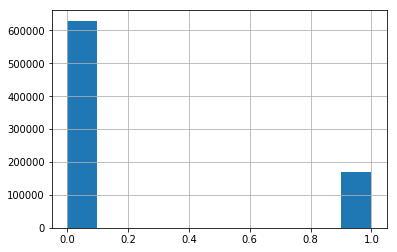

In [33]:
# Convert binary non-numeric variable into binary numeric variable. 
var_old = azdias_new[binary_categoricals_non_numeric[0]].unique()
print('The two non-numeric variables are: ', var_old) 

# Replace non-numeric with binary variables in current AZDIAS dataset. 
azdias_new["OST_WEST_KZ"].replace({'W' : 0.0,'O' : 1.0}, inplace = True)
# Set type to integer. 
azdias_new["OST_WEST_KZ"].astype('int', inplace=True)

# Verify success of conversion. 
var_new = azdias_new[binary_categoricals_non_numeric[0]].unique()   
print('The two converted variables are: ', var_new) 
azdias_new["OST_WEST_KZ"].hist()

In [34]:
# One-hot encode multi-level cotegoricals. 
azdias_reencoded = pd.get_dummies(data = azdias_new, columns = multi_level_categoricals)

#### Discussion 1.2.1: Re-Encode Categorical Features

My analysis identified numeric binary, non-numeric binary and multi-level categorical variables. Moving forward, the numeric binary variables do not need reencoding. I identified one non-numeric binary variable that I converted into a numeric binary variable. Finally, I decided to one-hot encode the multi-level cattegorial values in the AZDIAS dataset. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Get overview of all mixed features in features summary dataset. 
mixed_features = feat_info_clean[feat_info_clean.type == 'mixed']

mixed_features

,information_level,type,missing_or_unknown
attribute,,,
LP_LEBENSPHASE_FEIN,person,mixed,[0]
LP_LEBENSPHASE_GROB,person,mixed,[0]
PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
WOHNLAGE,building,mixed,[-1]
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

''' INFORMATION FROM Data_Dictionary.md
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''

# Display first 10 results for PRAEGENDE_JUGENDJAHRE in current AZDIAS dataset.
azdias_reencoded.PRAEGENDE_JUGENDJAHRE.head(10)

1     14.0
2     15.0
3      8.0
4      8.0
5      3.0
6     10.0
7      8.0
8     11.0
9     15.0
10     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [37]:
# PRAEGENDE_JUGENDJAHRE: Engineer two new variables. 

# Create dictionaries for the variables generation by decade and movement (mainstream vs. avantgarde). Both dictionaries 
# contain the original variables (1-15) as keys, and the respective decate (40-90) / a binary value for "Mainstream" vs. 
# "Aventgarde" respectively. 

generation_dict =   {
                    1: 40.0,
                    2: 40.0,
                    3: 50.0,
                    4: 50.0,
                    5: 60.0,
                    6: 60.0,
                    7: 60.0,
                    8: 70.0,
                    9: 70.0,
                    10: 80.0,
                    11: 80.0,
                    12: 80.0,
                    13: 80.0,
                    14: 90.0, 
                    15: 90.0
                    }

movement_dict =     {
                    1: 0.0,
                    2: 1.0,
                    3: 0.0,
                    4: 1.0,
                    5: 0.0,
                    6: 1.0,
                    7: 1.0,
                    8: 0.0,
                    9: 1.0,
                    10: 0.0,
                    11: 1.0,
                    12: 0.0,
                    13: 1.0,
                    14: 0.0, 
                    15: 1.0,
                    }

In [38]:
# Replace the original PRAEGENDE_JUGENDJAHRE from the current AZDIAS dataset with the two new columns. 

# Create two new columns as copies of original column. 
azdias_reencoded["DECADE"] = azdias_reencoded.PRAEGENDE_JUGENDJAHRE
azdias_reencoded["MOVEMENT"] = azdias_reencoded.PRAEGENDE_JUGENDJAHRE

# Drop the original column. 
azdias_reencoded.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)

# Replace values in two new columns with dictionary values. 
azdias_reencoded["DECADE"].replace(generation_dict, inplace=True)
azdias_reencoded["MOVEMENT"].replace(movement_dict, inplace=True)

In [39]:
# Verify successful replacement. 
print("First 10 rows in DECADE column: ")
display(azdias_reencoded["DECADE"].head(10))

print("First 10 rows in MOVEMENT column: ")
display(azdias_reencoded["MOVEMENT"].head(10))

First 10 rows in DECADE column: 


1     90.0
2     90.0
3     70.0
4     70.0
5     50.0
6     80.0
7     70.0
8     80.0
9     90.0
10    50.0
Name: DECADE, dtype: float64

First 10 rows in MOVEMENT column: 


1     0.0
2     1.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     1.0
9     1.0
10    0.0
Name: MOVEMENT, dtype: float64

In [40]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

''' INFORMATION FROM Data_Dictionary.md
### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
'''
# Display first 10 results for CAMEO_INTL_2015 in current AZDIAS dataset.
azdias_reencoded.CAMEO_INTL_2015.head(10)

1     51
2     24
3     12
4     43
5     54
6     22
7     14
8     13
9     15
10    51
Name: CAMEO_INTL_2015, dtype: object

In [41]:
# CAMEO_INTL_2015: Engineer two new variables. 

# Create dictionaries for the variables wealth and lifestage. Both dictionaries 
# contain the original numerical variables as keys, and the respective numerical value representing the 5 different wealth 
# statuses / life stages respectively. Unknown values listed in Data_Dictionary.md can be ignored as they have already been 
# listed as NaNs) 

wealth_dict =       {
                    '11': 1.0,
                    '12': 1.0,
                    '13': 1.0,
                    '14': 1.0,
                    '15': 1.0,
                    '21': 2.0,
                    '22': 2.0,
                    '23': 2.0,
                    '24': 2.0,
                    '25': 2.0,
                    '31': 3.0,
                    '32': 3.0,
                    '33': 3.0,
                    '34': 3.0, 
                    '35': 3.0,
                    '41': 4.0,
                    '42': 4.0,
                    '43': 4.0,
                    '44': 4.0, 
                    '45': 4.0,
                    '51': 5.0,
                    '52': 5.0,
                    '53': 5.0,
                    '54': 5.0, 
                    '55': 5.0                                                                                                                                        
                    }

lifestage_dict =    {
                    '11': 1.0,
                    '12': 2.0,
                    '13': 3.0,
                    '14': 4.0,
                    '15': 5.0,
                    '21': 1.0,
                    '22': 2.0,
                    '23': 3.0,
                    '24': 4.0,
                    '25': 5.0,
                    '31': 1.0,
                    '32': 2.0,
                    '33': 3.0,
                    '34': 4.0, 
                    '35': 5.0,
                    '41': 1.0,
                    '42': 2.0,
                    '43': 3.0,
                    '44': 4.0, 
                    '45': 5.0,
                    '51': 1.0,
                    '52': 2.0,
                    '53': 3.0,
                    '54': 4.0, 
                    '55': 5.0
                    }

In [42]:
# Create two new columns as copies of original column. 
azdias_reencoded["WEALTH"] = azdias_reencoded.CAMEO_INTL_2015
azdias_reencoded["LIFESTAGE"] = azdias_reencoded.CAMEO_INTL_2015

# Drop the original column. 
azdias_reencoded.drop("CAMEO_INTL_2015", axis = 1, inplace = True)

# Replace values in two new columns with dictionary values. 
azdias_reencoded["WEALTH"].replace(wealth_dict, inplace = True)
azdias_reencoded["LIFESTAGE"].replace(lifestage_dict, inplace = True)

In [43]:
# Verify successful replacement. 
print("First 10 rows in WEALTH column: ")
display(azdias_reencoded["WEALTH"].head(10))

print("First 10 rows in LIFESTAGE column: ")
display(azdias_reencoded["LIFESTAGE"].head(10))

First 10 rows in WEALTH column: 


1     5
2     2
3     1
4     4
5     5
6     2
7     1
8     1
9     1
10    5
Name: WEALTH, dtype: object

First 10 rows in LIFESTAGE column: 


1     1
2     4
3     2
4     3
5     4
6     2
7     4
8     3
9     5
10    1
Name: LIFESTAGE, dtype: object

In [44]:
# Review information on four remaining mixed-type features. 
'''INFORMATION FROM Data_Dictionary.md
### 1.11. LP_LEBENSPHASE_FEIN
Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households
'''

'''INFORMATION FROM Data_Dictionary.md
### 1.12. LP_LEBENSPHASE_GROB
Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households
'''

'''INFORMATION FROM Data_Dictionary.md
### 3.7. WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood
'''

'''INFORMATION FROM Data_Dictionary.md
### 8.6. PLZ8_BAUMAX
Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings
'''

'INFORMATION FROM Data_Dictionary.md\n### 8.6. PLZ8_BAUMAX\nMost common building type within the PLZ8 region\n- -1: unknown\n-  0: unknown\n-  1: mainly 1-2 family homes\n-  2: mainly 3-5 family homes\n-  3: mainly 6-10 family homes\n-  4: mainly 10+ family homes\n-  5: mainly business buildings\n'

In [45]:
# Drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB from dataset. 
azdias_reencoded.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"], axis = 1, inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

As specified in the instructions, for both PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 I created two new columns respectively. 

For PRAEGENDE_JUGENDJAHRE, I ignored the nation (east vs. west) as there were insufficient levels. However, I created new columns for the other two multi-level variables: DECADE and MOVEMENT. For decade, I implemented the corresponding decade values (40-90) representing the decades 1940ies to 1990ies. For the movement variables (Aventgarde vs. Mainstream) i used the binary variabled 0.0 and 1.0. 

For CAMEO_INTL_2015, I created new columns for WEALTH and LIFESTAGE by representing each of their five categorical sub-variables through numerical values (1.0-5.0). 

These were my engineering steps: 
1. Look up column information in Data_Dictionary.md
2. Display first few rows of multi-variable column 
3. Using the information from (1), create dictionaries with the original column values as key, and each corresponding relevant sub-variable (or numeric representation thereof) as value.  
4. Create two new columns as copies of original column respectively.
5. Drop the original column.
6. Replace values in the new columns with the corresponding dictionary values. 
7. Print the first 10 rows of each column to verify successful conversion. 

Besides the above two mixed-type features, I identified four additional mixed-type featured through the cleaned feat_info datatset: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, and PLZ8_BAUMAX. 

LP_LEBENSPHASE_FEIN: Even though this column contains potentially useful multi-level information for our alaysis, from the structure of the variables (some contain features such as age lifestage, age, household status) whereas others contain only a sub-set of this and other information) it is not possible to convert the information into discrete columns, without incorporating many unknown values. Furthermore, the included information (age, income, household type, lifestage) are already included in other more discrete features in this dataset. Therefore, I decided to drop this column. 

LP_LEBENSPHASE_GROB: This mixed-type feature contains aggregate information contained in LP_LEBENSPHASE_FEIN. Because this feature also included mixed combinations of some of the variables age, lifestage, income and numer of people in household, it was also not reasonable to convert the information into distinct columns. As with LP_LEBENSPHASE_FEIN, I decided to also drop this column as it replicated information already included in other more discrete features in this dataset.

WOHNLAGE: Even though I am not certain how much value this feature will contribute to our analysis, I decided to keep the information within the dataset. A review of the mixed_type values revealed that it would not be practical to convert these into separate columns. 

PLZ8_BAUMAX: Same as for WOHNLAGE. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# Ensure that the dataframe only contains the columns that should be passed to the algorithm functions.
removed_features = ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015", "LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"]

for feature in removed_features: 
    if feature in azdias_reencoded: 
        print("Error! this feature should be removed: ", feature)
    else: 
        print("Success! this feature is removed: ", feature)

Success! this feature is removed:  PRAEGENDE_JUGENDJAHRE
Success! this feature is removed:  CAMEO_INTL_2015
Success! this feature is removed:  LP_LEBENSPHASE_FEIN
Success! this feature is removed:  LP_LEBENSPHASE_GROB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    ### Convert missing value codes into NaNs. ################################################################################
    
    # Identify missing or unknown data values and convert them to NaNs.
    for attribute, missing_values_list in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        # Strip string values of formatting elements and split values.
        missing_values_list = missing_values_list.strip('[]').split(',')

        for value in missing_values_list: 
            # If value in missing values list is numeric, convert into integer type. 
            try:
                value = int(value)
            except:
                continue
            # Convert respective AZDIAS value to NaN. 
            df.loc[azdias[attribute] == value, attribute] = np.nan
    
    # Remove "X", "XX" values
    for col in df.columns:
        df = df.replace({col: ['XX', 'X']}, np.nan)
            
    ### Remove selected columns and rows. #####################################################################################
    
    # Remove columns with outlier features. 
    outliers = ["AGER_TYP", "GEBURTSJAHR", "TITEL_KZ", "ALTER_HH", "KK_KUNDENTYP", "KBA05_BAUMAX"]
    df_cleaned = df.drop(outliers, axis = 1, inplace = True)
    
    # Get number of missing values per row.
    missing_rows = df_cleaned[df_cleaned.isnull().sum(axis=1)]
    
    # Only use subset with few missing rows.
    df_new = df_cleaned[df_cleaned[missing_rows <= 25]] 
    df_new = df_new.fillna(df_new.mode().iloc[0])
                       
    ### Select, re-encode, and engineer column values. ########################################################################
    
    # Assess categorical variables in features summary dataset.
    categorical_variables = feat_info_clean[feat_info_clean.type == 'categorical']
                       
    # Iterate through categorical variables and classify whether binary or multi-level 
    binary_categoricals = []
    multi_level_categoricals = []

    for attribute in categorical_variables.index:
        if df_new[attribute].nunique() == 2:
            binary_categoricals.append(attribute)
        else:
            multi_level_categoricals.append(attribute)
    
    # Iterate through categorical variables list and check whether numeric or non-numeric 
    binary_categoricals_non_numeric = []

    for attribute in binary_categoricals: 
        values = df_new[attribute].unique() 

        for value in values: 
            if not np.isreal(value): 
                binary_categoricals_non_numeric.append(attribute)
                break
    
    # Replace non-numeric with binary variables in current AZDIAS dataset. 
    df_new["OST_WEST_KZ"].replace({'W' : 0.0,'O' : 1.0}, inplace = True)
    # Set type to integer. 
    df_new["OST_WEST_KZ"].astype('int', inplace=True)

    # One-hot encode multi-level cotegoricals. 
    df_reencoded = pd.get_dummies(data = df_new, columns = multi_level_categoricals)
    
    # PRAEGENDE_JUGENDJAHRE: Engineer two new variables. 
    # Create dictionaries for the variables generation by decade and movement (mainstream vs. avantgarde). Both dictionaries 
    # contain the original variables (1-15) as keys, and the respective decate (40-90) / a binary value for "Mainstream" vs. 
    # "Aventgarde" respectively. 

    generation_dict =   {
                        1: 40.0,
                        2: 40.0,
                        3: 50.0,
                        4: 50.0,
                        5: 60.0,
                        6: 60.0,
                        7: 60.0,
                        8: 70.0,
                        9: 70.0,
                        10: 80.0,
                        11: 80.0,
                        12: 80.0,
                        13: 80.0,
                        14: 90.0, 
                        15: 90.0
                        }

    movement_dict =     {
                        1: 0.0,
                        2: 1.0,
                        3: 0.0,
                        4: 1.0,
                        5: 0.0,
                        6: 1.0,
                        7: 1.0,
                        8: 0.0,
                        9: 1.0,
                        10: 0.0,
                        11: 1.0,
                        12: 0.0,
                        13: 1.0,
                        14: 0.0, 
                        15: 1.0,
                        }

    # Replace the original PRAEGENDE_JUGENDJAHRE from the current AZDIAS dataset with the two new columns. 
    # Create two new columns as copies of original column. 
    df_reencoded["DECADE"] = df_reencoded.PRAEGENDE_JUGENDJAHRE
    df_reencoded["MOVEMENT"] = df_reencoded.PRAEGENDE_JUGENDJAHRE

    # Drop the original column. 
    df_reencoded.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)

    # Replace values in two new columns with dictionary values. 
    df_reencoded["DECADE"].replace(generation_dict, inplace = True)
    df_reencoded["MOVEMENT"].replace(movement_dict, inplace = True)
    
    # CAMEO_INTL_2015: Engineer two new variables. 
    # Create dictionaries for the variables wealth and lifestage. Both dictionaries 
    # contain the original numerical variables as keys, and the respective numerical value representing the 5 different wealth 
    # statuses / life stages respectively. Unknown values listed in Data_Dictionary.md can be ignored as they have already been 
    # listed as NaNs) 

    wealth_dict =       {
                        '11': 1.0,
                        '12': 1.0,
                        '13': 1.0,
                        '14': 1.0,
                        '15': 1.0,
                        '21': 2.0,
                        '22': 2.0,
                        '23': 2.0,
                        '24': 2.0,
                        '25': 2.0,
                        '31': 3.0,
                        '32': 3.0,
                        '33': 3.0,
                        '34': 3.0, 
                        '35': 3.0,
                        '41': 4.0,
                        '42': 4.0,
                        '43': 4.0,
                        '44': 4.0, 
                        '45': 4.0,
                        '51': 5.0,
                        '52': 5.0,
                        '53': 5.0,
                        '54': 5.0, 
                        '55': 5.0                                                                                                                                        
                        }

    lifestage_dict =    {
                        '11': 1.0,
                        '12': 2.0,
                        '13': 3.0,
                        '14': 4.0,
                        '15': 5.0,
                        '21': 1.0,
                        '22': 2.0,
                        '23': 3.0,
                        '24': 4.0,
                        '25': 5.0,
                        '31': 1.0,
                        '32': 2.0,
                        '33': 3.0,
                        '34': 4.0, 
                        '35': 5.0,
                        '41': 1.0,
                        '42': 2.0,
                        '43': 3.0,
                        '44': 4.0, 
                        '45': 5.0,
                        '51': 1.0,
                        '52': 2.0,
                        '53': 3.0,
                        '54': 4.0, 
                        '55': 5.0
                        }
    # Create two new columns as copies of original column. 
    df_reencoded["WEALTH"] = df_reencoded.CAMEO_INTL_2015
    df_reencoded["LIFESTAGE"] = df_reencoded.CAMEO_INTL_2015

    # Drop the original column. 
    df_reencoded.drop("CAMEO_INTL_2015", axis = 1, inplace = True)

    # Replace values in two new columns with dictionary values. 
    df_reencoded["WEALTH"].replace(wealth_dict, inplace = True)
    df_reencoded["LIFESTAGE"].replace(lifestage_dict, inplace = True)

    # Drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB from dataset. 
    df_reencoded.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"], axis = 1, inplace = True)

    ### Return the cleaned dataframe. #########################################################################################
    return df_reencoded


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# Check the dataset for NaN values.  
print("Number of NaN values in current AZDIAS dataset: ", azdias_reencoded.isnull().sum().sum())

Number of NaN values in current AZDIAS dataset:  783801


In [49]:
# Replace NaN values.
azdias_reencoded = azdias_reencoded.fillna(azdias_reencoded.mode().iloc[0])

In [50]:
# Check if "X" or "XX" values remaining in dataset. 
print("'XX' values remaining: ", "XX" in azdias_reencoded.values)
print("'X' values remaining: ", "X" in azdias_reencoded.values)

'XX' values remaining:  True
'X' values remaining:  False


In [51]:
# Remove rows with "XX" values from dataset. 
index_XX = azdias_reencoded[azdias_reencoded.values == 'XX'].index
azdias_reencoded.drop(index_XX, inplace = True)

In [52]:
# Verify successful replacement. 
print("Number of NaN values in current AZDIAS dataset after replacement: ", azdias_reencoded.isnull().sum().sum())
print("'XX' values remaining: ", "XX" in azdias_reencoded.values)

Number of NaN values in current AZDIAS dataset after replacement:  0
'XX' values remaining:  False


In [53]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_reencoded), columns = azdias_reencoded.columns.tolist())

In [54]:
# Verify successful Feature Scaling. 
azdias_scaled.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,DECADE,MOVEMENT,WEALTH,LIFESTAGE
0,-1.766703,0.957969,-1.494352,1.537947,-1.040838,1.466047,0.958994,1.338929,-0.530280,1.010162,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,1.098185,-0.530280,1.176424,-1.249781
1,0.200460,0.957969,-1.494352,0.864596,-1.767140,-0.570960,0.244408,1.338929,1.885797,1.010162,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,1.098185,1.885797,-0.869133,0.766518
2,1.184042,0.957969,0.683483,-0.482104,1.138069,-0.570960,-1.184764,-0.791753,-0.530280,-0.311822,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,-0.267616,-0.530280,-1.550985,-0.577681
3,0.200460,-1.043875,0.683483,0.191246,0.411767,-1.249963,0.244408,-0.791753,-0.530280,1.010162,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,-0.267616,-0.530280,0.494572,0.094419
4,-1.766703,0.957969,-0.042462,-1.155455,1.138069,-0.570960,-0.470178,1.338929,-0.530280,1.010162,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,-1.633417,-0.530280,1.176424,0.766518
5,-0.783122,0.957969,-1.494352,1.537947,-1.767140,1.466047,0.958994,-0.081526,-0.530280,-0.311822,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,0.415285,-0.530280,-0.869133,-0.577681
6,-1.766703,-1.043875,-0.042462,0.191246,0.411767,-1.249963,0.244408,-0.791753,-0.530280,-1.633805,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,-0.267616,-0.530280,-1.550985,0.766518
7,0.200460,-1.043875,0.683483,0.864596,-1.040838,0.787045,-0.470178,-0.791753,1.885797,1.010162,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,0.415285,1.885797,-1.550985,0.094419
8,0.200460,0.957969,-0.768407,0.864596,-1.040838,0.108042,1.673581,0.628702,1.885797,-0.311822,...,-0.162591,-0.189596,-0.179837,-0.192827,-0.089783,0.0,1.098185,1.885797,-1.550985,1.438618
9,0.200460,0.957969,-0.768407,-0.482104,1.138069,0.108042,-1.184764,1.338929,-0.530280,-0.311822,...,-0.162591,-0.189596,-0.179837,5.186003,-0.089783,0.0,-1.633417,-0.530280,1.176424,-1.249781


### Discussion 2.1: Apply Feature Scaling

Before starting the Feature Scaling process, I first had to replace the remaining 783801 NaN values in the dataset. Similarly, I had to remove rows containing "X" or "XX" values. After this, feature scaling could be easily applied. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [55]:
# Apply PCA to the data.
pca_1 = PCA()
pca_1.fit_transform(azdias_scaled)

array([[  4.66554941e+00,  -3.94513471e+00,  -3.12461900e+00, ...,
         -2.00583785e-17,   5.58381264e-18,   3.12116467e-17],
       [ -5.17830272e-01,  -5.78149033e-01,  -3.15998401e+00, ...,
         -7.19626059e-17,   7.98714993e-18,   1.47199986e-17],
       [ -4.90933422e+00,   1.64843977e+00,  -1.48434187e+00, ...,
         -3.86231951e-17,   1.13540667e-18,   1.06030980e-17],
       ..., 
       [ -1.10731033e+00,  -4.00180485e+00,  -3.49878183e+00, ...,
         -9.36139520e-19,   4.59248490e-18,  -9.23447819e-19],
       [  6.47415931e+00,  -4.40115562e+00,   2.84175712e+00, ...,
          3.74126165e-18,   1.65870842e-18,   3.72455662e-19],
       [  4.94287894e-01,   2.53050540e+00,   1.85694365e+00, ...,
          4.23037932e-18,  -1.00112218e-18,  -1.58511602e-18]])

In [56]:
# Investigate the variance accounted for by each principal component.
# Define functions that visualize PCA results 
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,DECADE,MOVEMENT,WEALTH,LIFESTAGE
Dimension 1,0.0797,-0.0801,0.0142,-0.1871,0.1107,-0.0805,0.0506,0.0489,0.1474,-0.1005,...,0.0379,0.0572,0.0584,0.0574,0.0170,-0.0,0.0742,-0.1005,0.1826,-0.1089
Dimension 2,0.0569,0.2341,0.0376,0.0925,-0.2298,0.2204,-0.2069,-0.2169,0.0833,-0.0019,...,-0.0067,0.0022,0.0064,0.0118,0.0379,-0.0,-0.2324,-0.0019,0.0545,0.0133
Dimension 3,0.0352,0.0118,-0.3403,0.1306,-0.0539,0.0438,-0.1535,-0.0428,-0.0648,0.0895,...,-0.0049,0.0116,0.0244,0.0104,-0.0031,-0.0,-0.0523,0.0895,0.0117,-0.0118
Dimension 4,0.0281,-0.0299,0.1022,-0.0057,0.0150,-0.0207,-0.0491,0.0613,-0.0261,0.2859,...,-0.0077,-0.0112,-0.0017,-0.0078,-0.0015,-0.0,0.0324,0.2859,-0.0743,0.0396
Dimension 5,0.0205,0.0488,-0.0219,0.0524,-0.0285,0.0276,0.0233,-0.0943,-0.0452,-0.1160,...,0.0597,0.0385,0.0205,0.0211,-0.0057,-0.0,-0.0170,-0.1160,0.1005,-0.0627
Dimension 6,0.0164,0.0142,-0.0010,0.1267,-0.0145,-0.0355,-0.0457,0.0384,-0.2190,0.0029,...,0.0089,0.0447,0.0503,0.0526,0.0130,0.0,0.0315,0.0029,-0.0430,-0.0679
Dimension 7,0.0153,0.0272,0.0105,0.0042,-0.0118,-0.0203,-0.0134,0.0155,-0.0246,-0.0425,...,-0.0279,-0.0034,0.0192,-0.0142,0.0734,0.0,0.0206,-0.0425,-0.0516,-0.0370
Dimension 8,0.0137,0.0322,-0.0220,-0.0257,-0.0235,0.0368,-0.0647,0.0715,0.0125,-0.0304,...,-0.0613,-0.1186,-0.1094,-0.0890,-0.0235,-0.0,-0.0074,-0.0304,0.0433,0.0773
Dimension 9,0.0130,-0.0416,0.0164,0.0523,-0.0141,-0.0989,0.0346,-0.0858,-0.0195,0.0236,...,-0.0782,-0.0160,-0.0557,-0.0993,-0.0414,-0.0,0.0097,0.0236,-0.0197,0.2126
Dimension 10,0.0126,-0.0210,0.0230,-0.0818,0.0277,-0.0041,0.0550,0.0291,0.1369,-0.0177,...,0.0394,0.0305,0.0238,0.0224,0.0929,0.0,-0.0160,-0.0177,-0.0852,0.1821


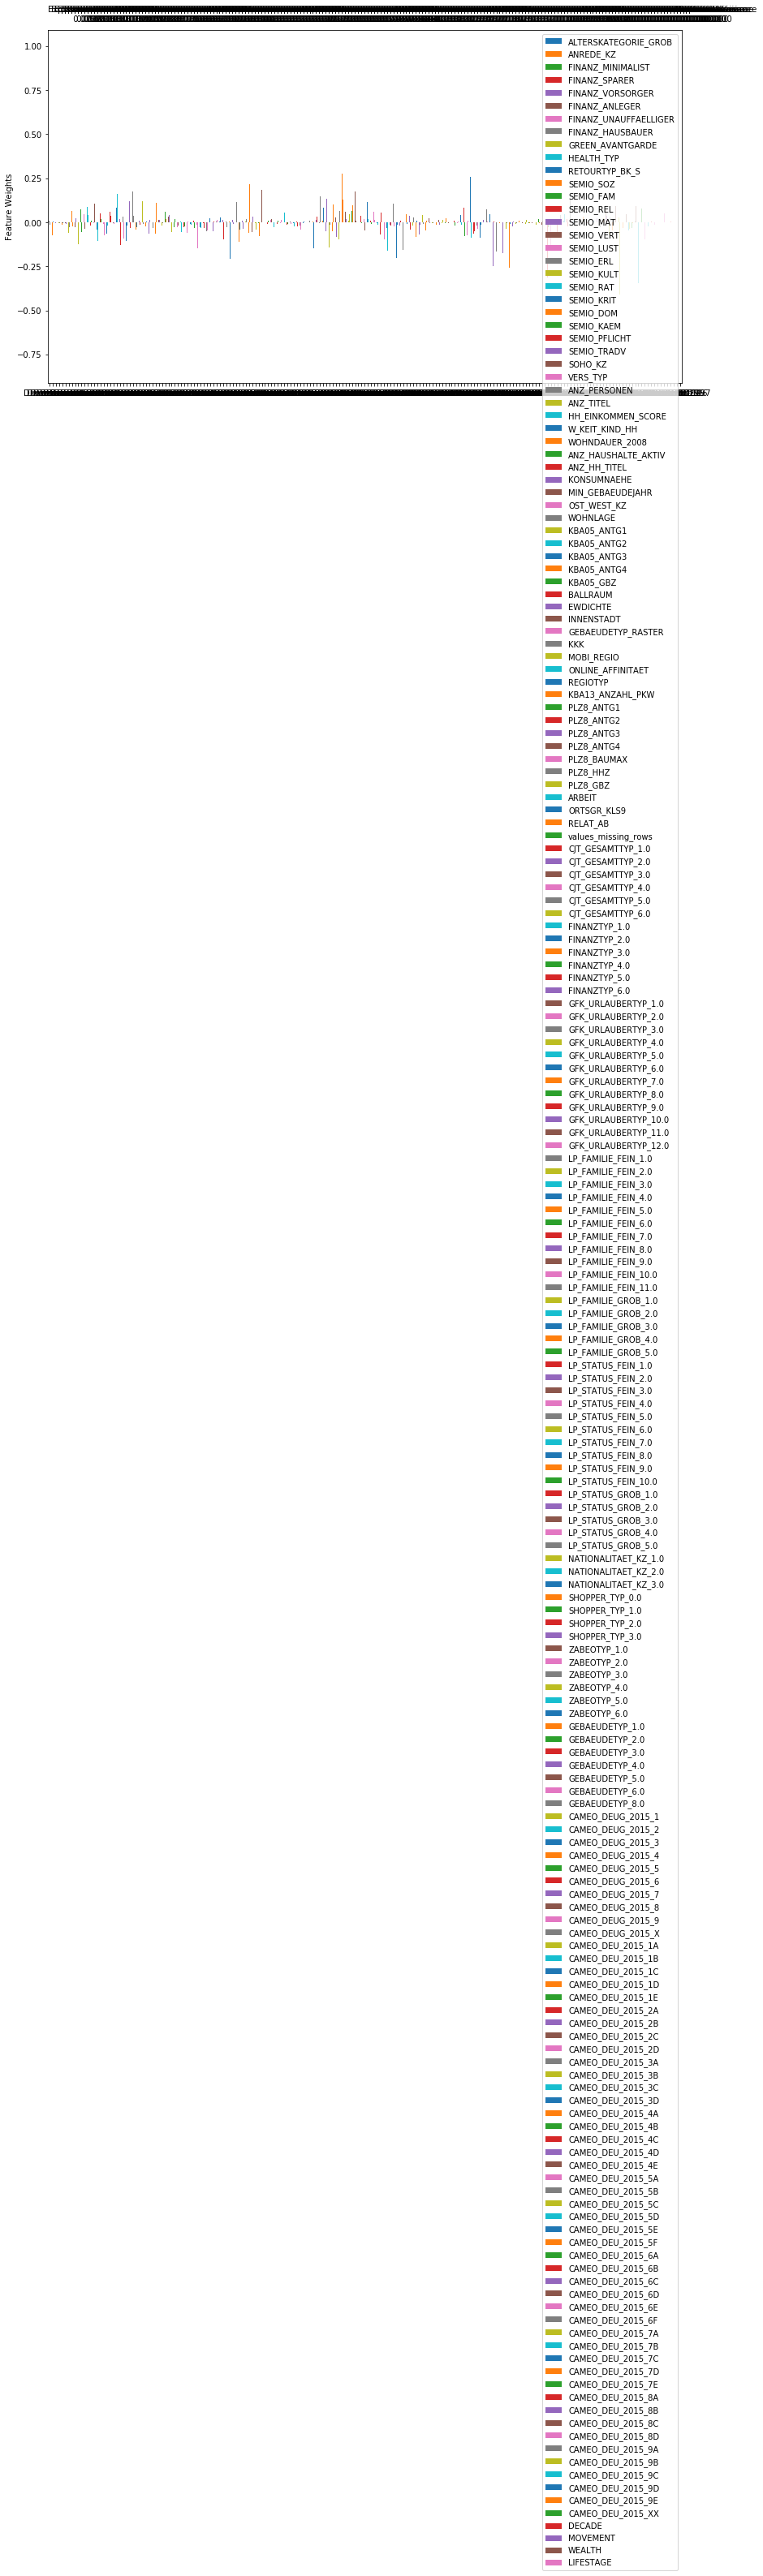

In [57]:
pca_results(azdias_scaled, pca_1)

In [58]:
def scree_plot(pca):
    '''
     Creates a scree plot associated with the principal components 
    
     INPUT: pca - the result of instantian of PCA in scikit learn
            
     OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

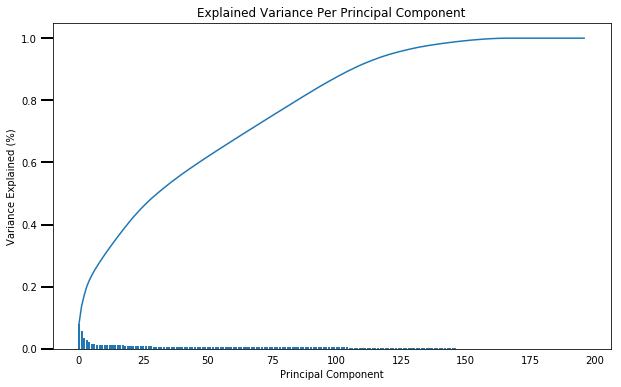

In [59]:
scree_plot(pca_1)

In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_2 = PCA(21)
azdias_pca = pca_2.fit_transform(azdias_scaled)

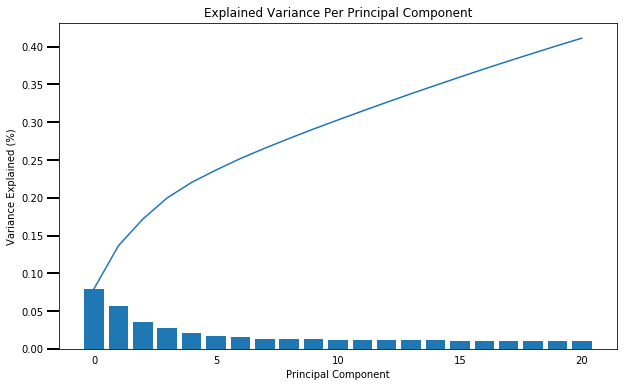

In [61]:
scree_plot(pca_2)

# Discussion 2.2: Perform Dimensionality Reduction

After applying PCA and visualizing the results in a scree plot, I decided to reduce the number of dimensions used within the second PCA to 21. The reason for this is that around 21 dimensions, the cumulative variance reaches around 0.4% and each addidional components adds around 0% to the cumulative variance.  

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [62]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(dataset, pca, n_element):
    weights_dataset = pd.DataFrame(pca.components_, columns=list(dataset.columns)).iloc[n_element-1]
    weights_dataset.sort_values(ascending = False, inplace = True)
    
    return weights_dataset

In [63]:
map_weights(dataset = azdias_scaled, pca = pca_2, n_element = 1)

LP_STATUS_GROB_1.0      0.193787
PLZ8_ANTG3              0.183503
WEALTH                  0.182637
HH_EINKOMMEN_SCORE      0.181637
PLZ8_ANTG4              0.178236
PLZ8_BAUMAX             0.174903
ORTSGR_KLS9             0.158082
EWDICHTE                0.156088
FINANZ_HAUSBAUER        0.147351
KBA05_ANTG4             0.129581
LP_STATUS_FEIN_1.0      0.126889
PLZ8_ANTG2              0.125775
KBA05_ANTG3             0.116148
ANZ_HAUSHALTE_AKTIV     0.115919
ARBEIT                  0.114540
CAMEO_DEUG_2015_9       0.113467
LP_STATUS_FEIN_2.0      0.113415
FINANZ_SPARER           0.110694
FINANZTYP_1.0           0.109746
RELAT_AB                0.108525
CAMEO_DEUG_2015_8       0.092197
LP_FAMILIE_FEIN_1.0     0.085370
LP_FAMILIE_GROB_1.0     0.085370
SEMIO_PFLICHT           0.080072
SEMIO_REL               0.075978
DECADE                  0.074225
ZABEOTYP_5.0            0.073671
GEBAEUDETYP_3.0         0.068125
SEMIO_RAT               0.066279
CAMEO_DEU_2015_8A       0.063201
          

In [64]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(dataset = azdias_scaled, pca = pca_2, n_element = 2)

ALTERSKATEGORIE_GROB     0.234053
FINANZ_VORSORGER         0.220420
ZABEOTYP_3.0             0.198965
SEMIO_ERL                0.179673
SEMIO_LUST               0.163919
RETOURTYP_BK_S           0.154773
W_KEIT_KIND_HH           0.119489
CJT_GESAMTTYP_2.0        0.108703
FINANZTYP_5.0            0.099634
LP_STATUS_FEIN_1.0       0.094932
FINANZ_MINIMALIST        0.092495
FINANZTYP_2.0            0.092494
FINANZ_HAUSBAUER         0.083268
SHOPPER_TYP_3.0          0.075240
CJT_GESAMTTYP_1.0        0.070803
SEMIO_KRIT               0.070769
NATIONALITAET_KZ_1.0     0.069576
FINANZTYP_6.0            0.068713
EWDICHTE                 0.064863
ORTSGR_KLS9              0.064030
PLZ8_ANTG3               0.063347
PLZ8_ANTG4               0.062798
GFK_URLAUBERTYP_4.0      0.059091
PLZ8_BAUMAX              0.058812
WOHNDAUER_2008           0.056382
SEMIO_KAEM               0.056228
LP_FAMILIE_FEIN_1.0      0.056196
LP_FAMILIE_GROB_1.0      0.056196
WEALTH                   0.054480
LP_STATUS_FEIN

In [65]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights(dataset = azdias_scaled, pca = pca_2, n_element = 3)

SEMIO_VERT               0.315676
SEMIO_FAM                0.257303
SEMIO_SOZ                0.255503
SEMIO_KULT               0.249469
FINANZTYP_5.0            0.136210
FINANZ_MINIMALIST        0.130590
SHOPPER_TYP_0.0          0.122154
ZABEOTYP_1.0             0.121696
SEMIO_REL                0.112652
MOVEMENT                 0.089511
GREEN_AVANTGARDE         0.089511
SEMIO_MAT                0.088993
RETOURTYP_BK_S           0.070763
ORTSGR_KLS9              0.070418
EWDICHTE                 0.069769
LP_STATUS_FEIN_10.0      0.064747
LP_STATUS_GROB_5.0       0.064747
SHOPPER_TYP_1.0          0.053329
PLZ8_BAUMAX              0.053226
W_KEIT_KIND_HH           0.052685
PLZ8_ANTG4               0.051098
PLZ8_ANTG3               0.049975
LP_STATUS_FEIN_3.0       0.047292
ZABEOTYP_6.0             0.046785
FINANZ_VORSORGER         0.043807
LP_STATUS_FEIN_1.0       0.038607
RELAT_AB                 0.037113
PLZ8_ANTG2               0.036877
ARBEIT                   0.035044
LP_STATUS_GROB

### Discussion 2.3: Interpret Principal Components

First Principal Component:
> Strongest Positive Correlation:
    - LP_STATUS_GROB_1.0      0.193787          Social status: low-income earners
    - PLZ8_ANTG3              0.183502          Number of 6-10 family houses in the PLZ8 region (none -> very high)
    - WEALTH                  0.182637          Household wealth 
    - HH_EINKOMMEN_SCORE      0.181638          Estimated household net income (highest -> very low) 

> Strongest Negative Correlation:
    - KBA05_GBZ              -0.180082          Number of buildings in the microcell (none -> very high)
    - PLZ8_ANTG1             -0.184599          Number of 1-2 family houses in the PLZ8 region (none -> very high)
    - MOBI_REGIO             -0.186226          Movement patterns (very high -> very low movement)
    - FINANZ_MINIMALIST      -0.187084          Low financial interest (very high -> very low) 

Second Principal Component: 
> Strongest Positive Correlation:
    - ALTERSKATEGORIE_GROB     0.234056         Estimated age based on given name analysis (young -> older) 
    - FINANZ_VORSORGER         0.220420         Financially prepared (very high -> very low) 
    - ZABEOTYP_3.0             0.198964         Energy consumption typology (green -> indifferent) 

> Strongest Negative Correlation:
    - FINANZ_ANLEGER          -0.206889         Financial Investor (very high -> very low) 
    - SEMIO_PFLICHT           -0.207550         Dutyful personality (high -> lowest) 
    - SEMIO_TRADV             -0.208227         Tradional-minded personality (high -> lowest) 
    - SEMIO_REL               -0.216288         Religious personality (high -> lowest)  
    - FINANZ_UNAUFFAELLIGER   -0.216900         Inconspicuous financial interest (very high -> very low) 
    - FINANZ_SPARER           -0.229798         Money-saver (very high -> very low) 
 
Third Principal Component: 
> Strongest Positive Correlation:
    - SEMIO_VERT               0.315717         Dreamful personality (highest -> lowest) 
    - SEMIO_FAM                0.257311         Family-minded personality (highest -> lowest)
    - SEMIO_SOZ                0.255512         Socially-minded personality (highest -> lowest)
    - SEMIO_KULT               0.249493         Cultural-minded personality (highest -> lowest)

> Strongest Negative Correlation:
    - SEMIO_ERL               -0.208151         Event-oriented personality (highest -> lowest)
    - SEMIO_KRIT              -0.265917         Critical-minded personality (highest -> lowest)
    - SEMIO_DOM               -0.276579         Dominant-minded personality (highest -> lowest)
    - SEMIO_KAEM              -0.309794         Combative attitude personality (highest -> lowest)
    - ANREDE_KZ               -0.340355         Gender (male -> female) 
    
Conclusion: ################################################################################################################## 

The first component has the highest positive correlation with features such as lower household income, wealth and number of multi-family houses in the region. The first component has a negative correlation with a high number of 1-2 family houses, low movement patterns and a greater financial interest. 

The second component has the highest positive correlation with features such as older estimated age, lower financial preparedness, and an indifferent energy consumption. It has a strong negative correlation with the features of a less dutiful, less traditional, less religious personality. 

The third component has the highest positive correlation with features such as a less dreamful, less family-minded, less socially- and culturally-minded personality. It has a stronger negative correlation with a less event-oriented, less critial-minded, less dominant-mined, less combative personality and female gender.  


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [66]:
#defining function that was given during the course.
def kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data)) 
    
    return score

In [67]:
# Over a number of different cluster counts run k-means clustering on the data and compute the average within-cluster distances.
centers = np.arange(20, 30, 2)
scores = []

for center in centers: 
    scores.append(kmeans_score(azdias_pca, center))
    print("cluster ", center , " calculated")

cluster  20  calculated
cluster  22  calculated
cluster  24  calculated
cluster  26  calculated
cluster  28  calculated


Text(0.5,1,'k-means score per cluster center')

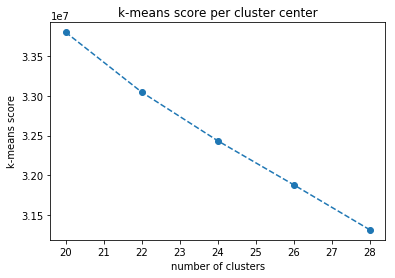

In [68]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle = '--', marker = 'o')
plt.xlabel("number of clusters")
plt.ylabel("k-means score")
plt.title("k-means score per cluster center")

In [69]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
azdias_kmeans = KMeans(22)
azdias_model = azdias_kmeans.fit(azdias_pca)
azdias_score = np.abs(azdias_model.score(azdias_pca)) 

azdias_cluster = azdias_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Because there appears a slight "elbow" in the k-means score at 22 clusters, I decided to use 22 clusters moving forward. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [70]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [71]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean the customer data. 
customers_clean = clean_data(customers, feat_info)

AttributeError: 'NoneType' object has no attribute 'isnull'

In [ ]:
# Replace NaN values in customer data. 
customers_reencoded = customers_clean.fillna(customers_clean.mode().iloc[0])

In [ ]:
# Apply Feature Scaling to customer data. 
# Apply feature scaling to the general population demographics data.
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_reencoded), columns = customers_reencoded.columns.tolist())

In [ ]:
# Verify successful Feature Scaling. 
customers_scaled.head(10)

In [ ]:
# Apply PCA transformations. 
customers_pca = pca_2.fit_transform(customers_scaled)

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain cluster predictions.
customers_score, customers_model = kmeans_score(customers_pca, 25)
customers_cluster = customers_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)

ax1.set_title('General Demographics Clusters')
sns.countplot(azdias_cluster, ax = ax1)

ax2.set_title('Customers Demographics Clusters')
sns.countplot(customers_cluster, ax = ax2)

plt.show()

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.